## 랜덤포레스트

[결정트리 포스팅](https://yganalyst.github.io/study/ML_chap5/)에서도 언급했듯이, 랜덤포레스트는 일반적으로 [배깅(또는 페이스팅)](https://yganalyst.github.io/study/ML_chap6-2/)을 적용한 결정트리의 앙상블이다.  

앞의 포스팅에서 사용했었던 `BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 앙상블을 만드는 대신  
결정트리에 최적화되어 있는 `RandomForestClassifier`를 사용할 수 있다(회귀는 `RandomForestRegressor`).  


다음 500개 트리로 이루어진 랜덤포레스트 분류기를 훈련시키는 코드를 보자.  

In [1]:
# moon dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

`RandomForestClassifier`는 (예외가 있지만)`DecisionTreeClassifier`와 `BaggingClassifier`의 매개변수를 모두 가지고 있다.  


예외인 옵션들의 기본값(변경불가)들은 다음과 같다. 
- `splitter` : 항상 `best`  
- `presort` : 항상 False  
- `max_samples` : 항상 1  
- `base_estimator` : 항상 지정된 매개변수를 사용한 결정트리 모델  

랜덤포레스트는 트리의 노드를 분할할 때 전체 변수 중에서 최선의 변수를 찾는 대신, 무작위로 선택한 변수 후보 중에서 최적의 변수를 찾는 식으로 무작위성을 더 주입한다([결정트리](https://yganalyst.github.io/study/ML_chap5/) 참고).  


이는 결국 트리를 더욱 다양하게 만들고 편향을 손해 보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만든다.  


다음은 `BaggingClassifier`를 사용해 랜덤포레스트와 유사하게 만든 것이다.  


In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random',
                                                  max_leaf_nodes=16),
                           n_estimators=500,
                           max_samples=1.0,
                           bootstrap=True,
                           n_jobs=-1)

### 엑스트라 트리  

앞에서 언급한 랜덤 포레스트의 핵심은 **트리를 더욱 무작위하게 만들기 위해, 일반적인 결정트리모델처럼 최적의 임계값을 찾는 대신 후보 변수를 사용해 무작위로 분할해 그 중 최상의 분할을 선택**하는 것이다.  


이러한 원리를 더 극단적으로 사용한 것을 랜덤트리 앙상블, 줄여서 **엑스트라 트리(Extra-Trees)** 라고 부른다.  


사이킷런에서는 이 두가지 모델을 모두 제공한다.  
`ExtraTreesClassifier`와 `RandomForesetClassifier`이며 Regressor도 같은 API를 제공한다.  

### 변수(features) 중요도  

랜덤포레스트의 또 다른 장점 중 하나가 변수의 상대적 중요도를 측정할 수 있다는 것이다.  


어떤 변수를 사용한 노드가 (전체 트리에 대해)평균적으로 불순도를 얼마나 감소시키는지 확인하여 중요도를 측정한다.  


이는 결국 가중치평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.  
> - 중요도 = `(현재 노드의 샘플 비율 X 불순도) - (왼쪽 자식 노드의 샘플 비율 X 불순도) - (오른쪽 자식노드의 샘플 비율 X 불순도)`  
> - 전체 중요도의 합으로 나누어 정규화  
> - 여기서 샘필 비율이란, 전체 샘플 수에 대한 해당 노드의 샘플 수  
> - 마지막으로 랜덤포레스트의 변수 중요도는, 각 결정트리의 `변수 중요도의 합 / 트리 수` 이다.   

사이킷런은 훈련 후 변수마다 자동으로 이 중요도를 계산하고 전체 합이 1이 되도록 정규화를 한다.  
이는 `feature_importances_`에 저장되어 있다.  


다음 코드는 iris데이터셋에 랜덤포레스트를 훈련시키고 중요도를 출력한 것이다.  

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09193700831457226
sepal width (cm) 0.02303133424063586
petal length (cm) 0.4503310122507622
petal width (cm) 0.43470064519402973


변수는 총 4개이고, 위의 4개 점수를 합하면 1이된다.  
즉, 꽃잎의 길이(petal length)와 꽃잎의 너비(petal width)가 각각 45%, 43%로 가장 높다.  


이와 유사하게 이전 포스팅 [분류(Classification)](https://yganalyst.github.io/study/ML_chap2/)에서 다루었던 MNIST데이터셋에도 적용해 본다면 다음과 같다.  

In [17]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist['data'], mnist['target'],test_size = 0.2, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

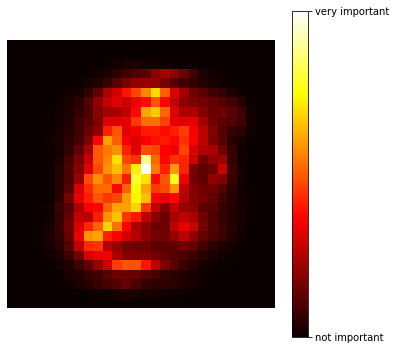

In [40]:
scores = rnd_clf.feature_importances_.reshape(28,28)
plt.figure(figsize=(6,6))
plt.imshow(scores, cmap = matplotlib.cm.hot,
          interpolation="nearest")
plt.axis("off")
cbar = plt.colorbar(ticks=[scores.min(),
                          scores.max()])
cbar.ax.set_yticklabels(['not important', 'very important'])
plt.show()

총 784개(28X28)의 변수들의 중요도를 나타내어 준다.  